# DSC 106 - Project 3

In [1]:
#libraries
import datetime as dt
import xarray as xr
import fsspec
import s3fs
import os.path
import matplotlib.pyplot as plt

# make datasets display nicely
xr.set_options(display_style="html")  

#magic fncts #put static images of your plot embedded in the notebook
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [2]:
def get_geo_data(sat,lyr,idyjl):
    # arguments
    # sat   goes-east,goes-west,himawari
    # lyr   year
    # idyjl day of year
    
    d = dt.datetime(lyr,1,1) + dt.timedelta(days=idyjl)
    fs = s3fs.S3FileSystem(anon=True) #connect to s3 bucket!

    #create strings for the year and julian day
    imon,idym=d.month,d.day
    syr,sjdy,smon,sdym = str(lyr).zfill(4),str(idyjl).zfill(3),str(imon).zfill(2),str(idym).zfill(2)
    
    #use glob to list all the files in the directory
    if sat=='goes-east':
        file_location,var = fs.glob('s3://noaa-goes16/ABI-L2-SSTF/'+syr+'/'+sjdy+'/*/*.nc'),'SST'
    if sat=='goes-west':
        file_location,var = fs.glob('s3://noaa-goes17/ABI-L2-SSTF/'+syr+'/'+sjdy+'/*/*.nc'),'SST'
    if sat=='himawari':
        file_location,var = fs.glob('s3://noaa-himawari8/AHI-L2-FLDK-SST/'+syr+'/'+smon+'/'+sdym+'/*/*L2P*.nc'),'sea_surface_temperature'
    
    #make a list of links to the file keys
    if len(file_location)<1:
        return file_ob
    file_ob = [fs.open(file) for file in file_location]        #open connection to files
    
    #open all the day's data
    ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time') #note file is super messed up formatting
    
    #clean up coordinates which are a MESS in GOES
    #rename one of the coordinates that doesn't match a dim & should
    if not sat=='himawari':
        ds = ds.rename({'t':'time'})
        ds = ds.reset_coords()
    else:
        ds = ds.rename({'ni':'x','nj':'y'}) #for himawari change dims to match goes 
    
    #put in to Celsius
    #ds[var] -= 273.15   #nice python shortcut to +- from itself a-=273.15 is the same as a=a-273.15
    #ds[var].attrs['units'] = '$^\circ$C'
   
    return ds

In [4]:
%%time

lyr, idyjl = 2020, 210

ds = get_geo_data('goes-east',lyr,idyjl)

CPU times: user 12 s, sys: 4.62 s, total: 16.6 s
Wall time: 9min 38s


/var/folders/q2/cgg1l8w16k1g8gr2znypm6sr0000gn/T/ipykernel_40927/3220207789.py:33: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({'t':'time'})


In [5]:
ds

<xarray.Dataset> Size: 6GB
Dimensions:                                                 (time: 24, y: 5424,
                                                             x: 5424,
                                                             number_of_time_bounds: 2,
                                                             number_of_image_bounds: 2,
                                                             number_of_LZA_bounds: 2,
                                                             number_of_SZA_bounds: 2,
                                                             SST_night_only_emissive_band: 1,
                                                             SST_day_night_emissive_bands: 4)
Coordinates:
  * y                                                       (y) float32 22kB ...
  * x                                                       (x) float32 22kB ...
Dimensions without coordinates: time, number_of_time_bounds,
                                number_of_image_bounds, number_of_LZA_bounds,
                                number_of_SZA_bounds,
                                SST_night_only_emissive_band,
                                SST_day_night_emissive_bands
Data variables: (12/54)
    SST                                                     (time, y, x) float32 3GB dask.array<chunksize=(1, 226, 226), meta=np.ndarray>
    DQF                                                     (time, y, x) float32 3GB dask.array<chunksize=(1, 226, 226), meta=np.ndarray>
    time_bounds                                             (time, number_of_time_bounds) datetime64[ns] 384B dask.array<chunksize=(1, 2), meta=np.ndarray>
    goes_imager_projection                                  (time) int32 96B ...
    y_image_bounds                                          (time, number_of_image_bounds) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    x_image_bounds                                          (time, number_of_image_bounds) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...                                                      ...
    day_solar_zenith_angle                                  float32 4B 85.0
    night_solar_zenith_angle                                float32 4B 95.0
    SST_night_only_emissive_wavelength                      (SST_night_only_emissive_band) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    SST_day_night_emissive_wavelengths                      (SST_day_night_emissive_bands) float32 16B dask.array<chunksize=(4,), meta=np.ndarray>
    SST_night_only_emissive_band_id                         (SST_night_only_emissive_band) int8 1B dask.array<chunksize=(1,), meta=np.ndarray>
    SST_day_night_emissive_band_ids                         (SST_day_night_emissive_bands) int8 4B dask.array<chunksize=(4,), meta=np.ndarray>
Attributes: (12/34)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    long_name:                 standard deviation of the difference of the ob...
    _FillValue:                -999.0
    units:                     K
    grid_mapping:              goes_imager_projection
    cell_methods:              quantitative_local_zenith_angle: sum retrieval...
    id:                        14a121c9-41b8-4552-9c28-69e6bcd4952f

CPU times: user 1.62 s, sys: 189 ms, total: 1.81 s
Wall time: 1.57 s


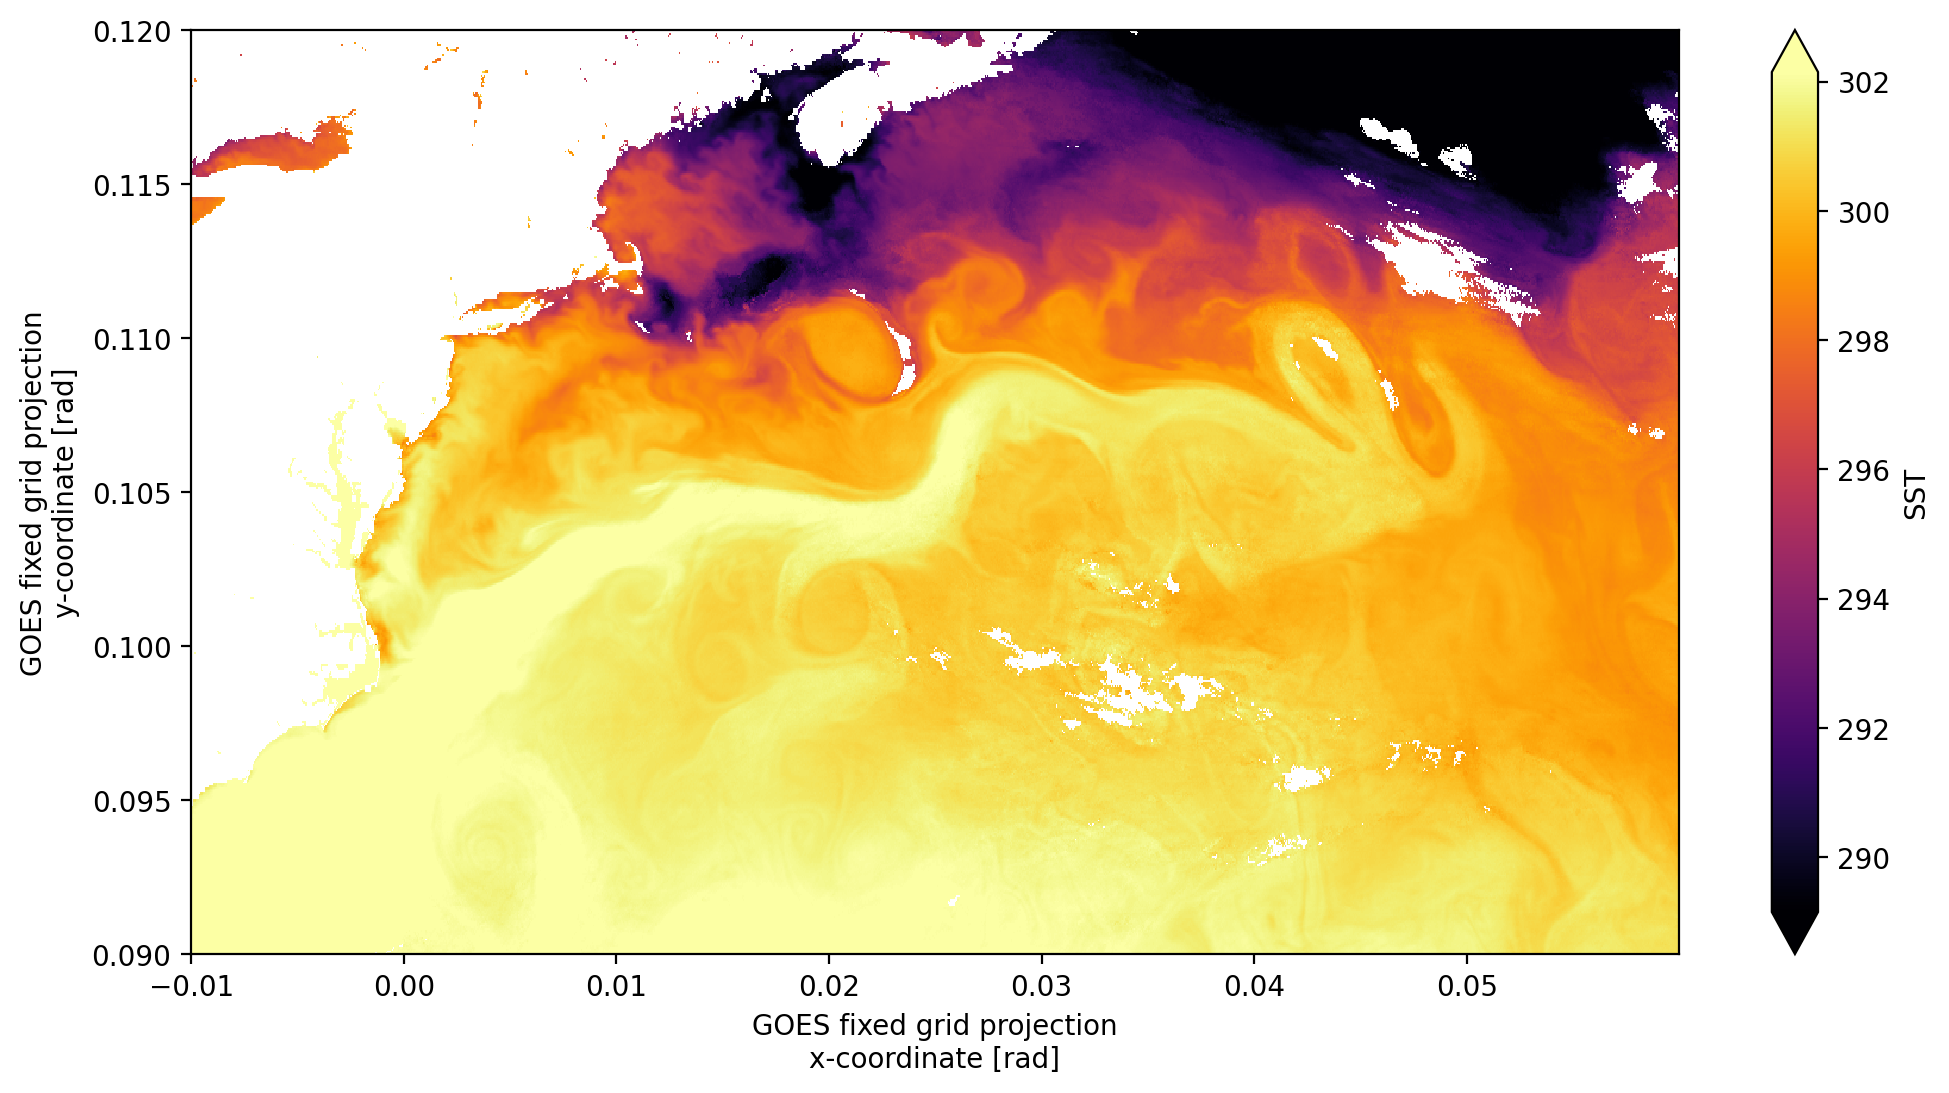

In [ ]:
%%time
subset = ds.sel(x=slice(-0.01,0.06),y=slice(0.12,0.09))  #reduce to GS region
masked = subset.SST.where(subset.DQF==0)
mean_dy = masked.mean('time',skipna=True)   #here I want all possible values so skipna=True
mean_dy.plot(vmin=16+273.15,vmax=29+273.15,cmap='inferno')

In [ ]:
sst = ds['SST'].isel(time=0)

NameError: name 'ds' is not defined